#### DONT RUN THE ABOVE (1st CELL) BECAUSE I WROTE IN THE 2ND CELL A FUNCTION (SAME) FOR THE 2 CASES

In [1]:
import pyedflib
import mylib 
import mvar
import mygraph
import numpy as np
from igraph import Graph
from igraph import *

#%% Load data and store into a dataframe

f = pyedflib.EdfReader('../data/S001R01.edf')

# mylib.print_some_stuff(f)

data = mylib.edfToDataFrame(f)

f._close()

#%%

data = data.T.values
N, n = data.shape
p = 3
A_est, sigma = mvar.mvar_fit(data, p)
sigma = np.diag(sigma)  # DTF + PDC support diagonal noise

# compute DTF
D, freqs = mvar.DTF(A_est, sigma)

# compute PDC
P, freqs = mvar.PDC(A_est, sigma)

# take take a graph relative to a specific frequency

freq = 10 # this has to be chosen better

D = D[np.where(freqs == mylib.find_nearest(freqs, freq)),:,:].reshape(64, 64)

G = Graph.Weighted_Adjacency(D.tolist())

G = mygraph.applyTreshold(G, 0.2)


OSError: can not open file, no such file or directory

In [3]:
### I built a function for both cases /eyes-open and closed--It returns the graph just like before

import pyedflib
import mylib 
import mvar
import mygraph
import numpy as np
from igraph import Graph
from igraph import *
from collections import defaultdict




def receive_data(case):
    #Read the data
    data = mylib.edfToDataFrame(case)
    case._close()

    #%%
    data = data.T.values
    N, n = data.shape
    p = 3
    A_est, sigma = mvar.mvar_fit(data, p)
    sigma = np.diag(sigma)  # DTF + PDC support diagonal noise
    # compute DTF
    D, freqs = mvar.DTF(A_est, sigma)
    # compute PDC
    P, freqs = mvar.PDC(A_est, sigma)
    # take take a graph relative to a specific frequency
    freq = 10 # this has to be chosen better
    D = D[np.where(freqs == mylib.find_nearest(freqs, freq)),:,:].reshape(64, 64)
    G = Graph.Weighted_Adjacency(D.tolist())
    G = mygraph.applyTreshold(G, 0.2)
    return(G)


case_open = pyedflib.EdfReader('./data/S001R01.edf')
G_open = receive_data(case_open)

case_closed = pyedflib.EdfReader('./data/S001R02.edf')
G_closed = receive_data(case_closed)


    
    

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

### Use this if we wanna use an unweighted graph

G = np.matrix(G.get_adjacency()._get_data())

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from igraph import *
import igraph



#Reverse side of the head
#Given an adjacency matrix return the graph with fixed positions

def pos_Igraph(Adj, do_plot):
    chan_loc = pd.read_csv("channels_topology.csv", sep=';', decimal=',') 
    pos = {row[0]: (row[1],row[2]) for row in chan_loc.values}
    dat = pd.DataFrame(Adj, columns = pos.keys())
    dat.set_index(dat.columns, inplace=True)
    g=Graph(64)
    g = Graph.Weighted_Adjacency((Adj).tolist())
    i=0
    for n,p in pos.items():
        g.vs[i]["coordinates"] = p
        g.vs[i]["name"] = n
        i=i+1
    if do_plot==True:
        return(plot(g,layout=g.vs["coordinates"],vertex_label=pos.items()))
    else:
        
        return(g)

### Point 4.1

#### Weighted graph

### 4.1 Number and composition (list of nodes) of the communities



Estimate the number of partitions using Louvain modularity 
~ Modularity based approach
https://en.wikipedia.org/wiki/Louvain_Modularity

In [6]:
import louvain

def louvain(G):
    
    louvain.set_rng_seed(123452)
    weights = G.es['weight']
    d=G.degree()
    G.vs['degree']=d
    G = np.matrix(G.get_adjacency(attribute='weight').data)
    G = pos_Igraph(G,do_plot=False)
    partition = louvain.find_partition(G, louvain.ModularityVertexPartition, weights=weights)
    return(partition,G)



In [5]:
part_open,G_open = louvain(G_open)
print("The estimated number of communities for eyes-open case is",len(set(part_open.membership)))
print('\n')
print("Communities")
for n in range(0,len(part_open)):
    print('Community number', n, '- size:', len(part_open[n]))

NameError: name 'G_open' is not defined

In [31]:
#Create a dictionary whith keys as channels (names of our nodes) and values the community they belong
print("Case: eyes-open")
comm_detect = dict(zip(G_open.vs['name'], part_open.membership))
print("A dictionary whith keys as channels (names of our nodes) and values the community they belong:")
print('\n')
new_dict = {}
for pair in comm_detect.items():
    if pair[1] not in new_dict.keys():
        new_dict[pair[1]] = []

    new_dict[pair[1]].append(pair[0])

print(dict(sorted(new_dict.items())))

Case: eyes-open
A dictionary whith keys as channels (names of our nodes) and values the community they belong:


{0: ['F3', 'Ft7', 'Fc5', 'Cz', 'P7', 'P1', 'Pz', 'P8', 'P6', 'P4', 'Tp7', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Tp8', 'Cp6', 'Cp4', 'Cp2', 'Iz'], 1: ['Afz', 'Af8', 'Fz', 'F8', 'Fc3', 'Fc1', 'T7', 'C5', 'C2', 'Oz', 'O2', 'Po3', 'P2'], 2: ['Af4', 'F7', 'F6', 'F4', 'F2', 'O1', 'Po7', 'Poz', 'Po4', 'P5', 'P3'], 3: ['Fp1', 'Fp2', 'Af7', 'Af3', 'F5', 'F1', 'T9', 'T10', 'T8', 'C6', 'C4'], 4: ['Fpz', 'Fcz', 'Ft8', 'Fc6', 'Fc4', 'Fc2', 'C3', 'C1', 'Po8']}


In [9]:
part_closed,G_closed = louvain(G_closed)
print("The estimated number of communities for eyes-closed case is",len(set(part_closed.membership)))
print('\n')
print("Communities")
for n in range(0,len(part_closed)):
    print('Community number', n, '- size:', len(part_closed[n]))

The estimated number of communities for eyes-closed case is 7


Communities
Community number 0 - size: 17
Community number 1 - size: 10
Community number 2 - size: 10
Community number 3 - size: 9
Community number 4 - size: 7
Community number 5 - size: 6
Community number 6 - size: 5


In [30]:
#Create a dictionary whith keys as channels (names of our nodes) and values the community they belong
print("Case: eyes-closed")
comm_detect = dict(zip(G_closed.vs['name'], part_closed.membership))
print("A dictionary whith keys as channels (names of our nodes) and values the community they belong:")
print('\n')
new_dict = {}
for pair in comm_detect.items():
    if pair[1] not in new_dict.keys():
        new_dict[pair[1]] = []

    new_dict[pair[1]].append(pair[0])

print(dict(sorted(new_dict.items())))

Case: eyes-closed
A dictionary whith keys as channels (names of our nodes) and values the community they belong


{0: ['Ft7', 'Fc5', 'Cz', 'P1', 'Pz', 'P8', 'P6', 'P4', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Tp8', 'Cp6', 'Cp4', 'Cp2', 'Iz'], 1: ['Fpz', 'Fp1', 'Fcz', 'Ft8', 'Fc6', 'Fc4', 'Fc2', 'C3', 'C1', 'C4'], 2: ['Fp2', 'Af7', 'Af3', 'F5', 'F3', 'F1', 'T9', 'T10', 'T8', 'C6'], 3: ['Fz', 'F8', 'Fc3', 'Fc1', 'Po3', 'Po8', 'P7', 'P2', 'Tp7'], 4: ['Afz', 'Af8', 'T7', 'C5', 'C2', 'Oz', 'O2'], 5: ['Af4', 'F7', 'F6', 'F4', 'F2', 'P3'], 6: ['O1', 'Po7', 'Poz', 'Po4', 'P5']}


### 4.2 Graphical Representation of the Community Structure

At rest in eyes-open conditions


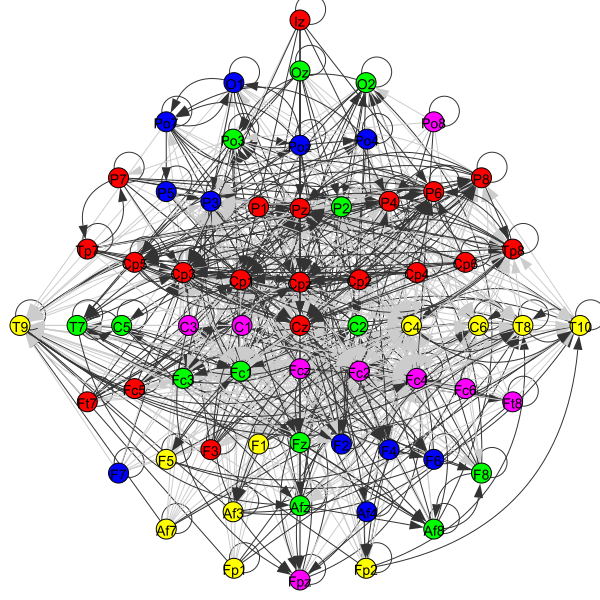

In [11]:
print("At rest in eyes-open conditions")
plot(part_open,layout=G_open.vs["coordinates"],vertex_label=G_open.vs["name"])

At rest in eyes-closed conditions


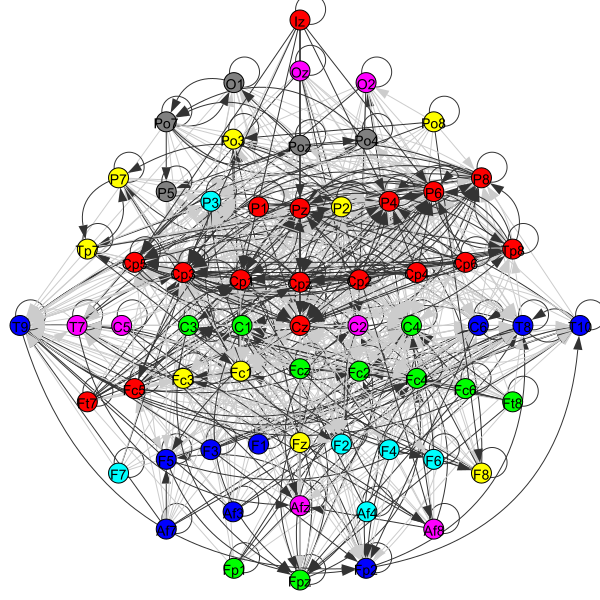

In [12]:
print("At rest in eyes-closed conditions")
plot(part_closed,layout=G_closed.vs["coordinates"],vertex_label=G_closed.vs["name"])

### 4.3 Modularity-based vs Information Theory-based approaches

##### Information Theory based approach ~ Infomap  

In [15]:
##Case OPEN

weights = G_open.es['weight']
comms = G_open.community_infomap(edge_weights = weights,trials = 50)
membership = comms.membership
print("The estimated number of communities for eyes-open case is",len(comms))

The estimated number of communities for eyes-open case is 1


In [14]:
##Case CLOSED

weights = G_closed.es['weight']
comms = G_closed.community_infomap(edge_weights = weights,trials = 50)
membership = comms.membership
print("The estimated number of communities for eyes-closed case is",len(comms))

The estimated number of communities for eyes-closed case is 1


Graph for both cases


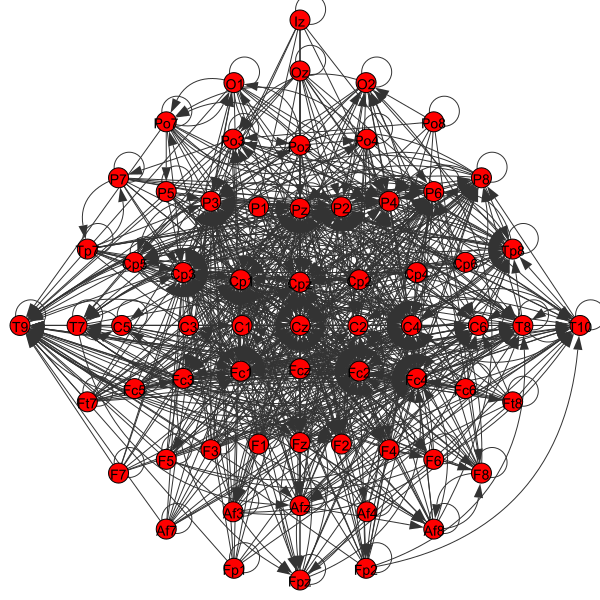

In [28]:
print("Graph for both cases")
plot(comms,layout=G_open.vs["coordinates"],vertex_label=G_open.vs["name"])
#plot(comms,layout=G_closed.vs["coordinates"],vertex_label=G_closed.vs["name"])

 Infomap always finds a single community containing all nodes of the network. However, a modularity-based methods, such as the Louvain method,finds a few communities (always more than one for both rest cases) for the specific average degree of our network. These results show that given the specified density of our network that we used the louvain algorithm (modularity based approach) tends to find a few small communities while the infomap method (information theory approach) it detects a single community in the same network with these specific dense connections.